In [40]:
# using Pkg
# Pkg.add(url="https://github.com/sdBrinkmann/HPFilter.jl")


In [41]:
using HPFilter

using Random
using LinearAlgebra
using Statistics
using Distributions
using ProgressMeter
using SpecialFunctions
using XLSX


using Plots
using StatsPlots  
using Distributions
using DataFrames

In [42]:

file_path = "C:/Users/marti/OneDrive - University of Copenhagen/Økonomi/9. semester/Empirical macro/State-Space-Model-Estimation-1/Harvey/data/quarterly_gdp.xlsx"
sheet_name = "Sheet 1"

data = XLSX.readtable(file_path, sheet_name) |> DataFrame

println(data)

num_obs = size(data, 1)
println("Number of observations: ", num_obs)


134×3 DataFrame
 Row │ Date    Value  recesion 
     │ Any     Any    Any      
─────┼─────────────────────────
   1 │ 1991K1  364.6  1
   2 │ 1991K2  364.7  1
   3 │ 1991K3  368.6  1
   4 │ 1991K4  364.5  1
   5 │ 1992K1  371.5  0
   6 │ 1992K2  367.9  0
   7 │ 1992K3  377.2  0
   8 │ 1992K4  375.4  1
   9 │ 1993K1  371.8  1
  10 │ 1993K2  370    1
  11 │ 1993K3  373.2  0
  12 │ 1993K4  375.7  0
  13 │ 1994K1  385.1  0
  14 │ 1994K2  391.5  0
  15 │ 1994K3  393.3  0
  16 │ 1994K4  399.8  0
  17 │ 1995K1  404.2  0
  18 │ 1995K2  402.5  0
  19 │ 1995K3  404    0
  20 │ 1995K4  406.7  0
  21 │ 1996K1  407.8  0
  22 │ 1996K2  418.3  0
  23 │ 1996K3  419    0
  24 │ 1996K4  419.1  0
  25 │ 1997K1  424.8  0
  26 │ 1997K2  431.6  0
  27 │ 1997K3  429.7  0
  28 │ 1997K4  430.9  0
  29 │ 1998K1  437.5  0
  30 │ 1998K2  434    0
  31 │ 1998K3  441.2  0
  32 │ 1998K4  444.1  0
  33 │ 1999K1  447.8  0
  34 │ 1999K2  449.8  0
  35 │ 1999K3  451.7  0
  36 │ 1999K4  459.7  0
  37 │ 2000K1  462.9  0


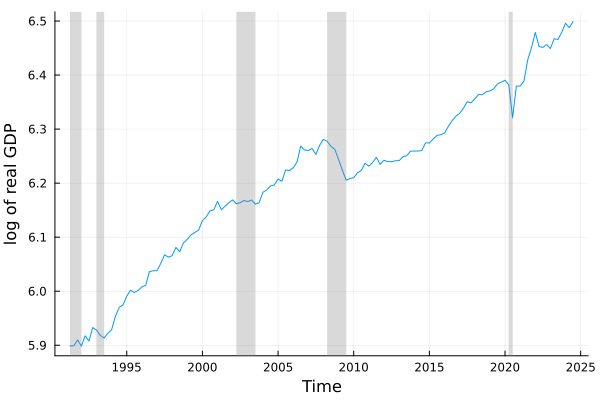

In [43]:
y = data[:, 2]
y = log.(y)
dates = data[:, 1]


for i in 1:length(dates)
    year = parse(Int, dates[i][1:4])
    quarter = parse(Int, dates[i][6])
    dates[i] = year + quarter/4
end

dates = Float64.(dates)


recesion = data[:, 3]
recesion = parse.(Int, recesion) 



# Identify the recession intervals
recession_periods = []
inside_recession = false
start_index = 0


for i in 1:length(recesion)
    if recesion[i] == 1 && !inside_recession
        inside_recession = true
        start_index = i
    elseif recesion[i] == 0 && inside_recession
        inside_recession = false
        push!(recession_periods, (start_index, i-1))
    end
end

if inside_recession
    push!(recession_periods, (start_index, length(recesion)))
end

if inside_recession
    push!(recession_periods, (start_index, length(recesion)))
end

#plot
p = plot(dates, y, xlabel="Time", ylabel="log of real GDP", label=false)
# Add vertical shaded areas for each recession period
for (start, stop) in recession_periods
    vspan!(p, [dates[start], dates[stop]], fillcolor=:gray, alpha=0.3, label=false)
end

p


## Apply HP and Butterworth filters

In [44]:
# HP filter with λ = 1600
hp = HP(y, 1600)
println(size(hp))

cycle_hp = y .- hp



(134,)


134-element Vector{Float64}:
  0.013613930013118392
  0.008082306324686428
  0.012904885781011899
 -0.00411704482473052
  0.00902513651034198
 -0.006655444014379341
  0.012278625794313491
  0.0013569063791649683
 -0.014553617009772424
 -0.02584639871207095
 -0.023859844762826654
 -0.023997273678122433
 -0.006276994496491106
  ⋮
  0.023665786192612615
  0.045390728430240834
  0.012791335030959416
  0.004748244368430576
  0.0033212769342139126
 -0.01024004724151606
  0.0013101062533777963
 -0.006573060151983334
  7.272950237524611e-5
  0.010478486928032993
 -0.004198778499678646
  0.000659987835340381

In [45]:
# import Pkg; Pkg.add("DSP")

In [46]:
using DSP  # For digital signal processing functions


fs = 4  # Replace with the appropriate value for your data

N = 12  # Number of periods for the cutoff
fc = fs / N  # Cutoff frequency in the same units as fs

# Ensure the cutoff frequency is valid
if fc >= fs / 2
    error("Cutoff frequency must be less than half the sampling frequency")
end

# Define the filter order
order = 4  # Adjust as needed

# Design the Butterworth low-pass filter
responsetype = Lowpass(fc; fs=fs)
designmethod = Butterworth(order)
butter_filter = digitalfilter(responsetype, designmethod)

# Apply the filter to your data using filtfilt to avoid phase distortion
trend_butterworth = filtfilt(butter_filter, y)

# Output the size of the trend component
println(size(trend_butterworth))

# (Optional) Plot the original data and the extracted trend
plot(dates, y, label="Original Data")
plot!(dates, trend_butterworth, label="Trend (Butterworth Filtered)")

cycle_butterworth = y .- trend_butterworth


(134,)


134-element Vector{Float64}:
 -0.0004905071174370335
 -0.003769580161974595
  0.003578799547531375
 -0.010481079847572516
  0.0061356508110774755
 -0.005634732221982297
  0.017385923433545614
  0.010283073857890734
 -0.0026187698291844086
 -0.012220584289939218
 -0.010176274965187027
 -0.011890813848930648
  0.002962542846143279
  ⋮
  0.018895499739390864
  0.03530494422739672
  7.020721681527675e-5
 -0.007854144581499689
 -0.006967645720223459
 -0.016964843250935502
 -0.0016219008115054834
 -0.00633476542468614
  0.0023324256751351413
  0.013433080675043563
 -0.0017561866903639256
  0.001714766232431053

## Load results from STMs

In [47]:
using JLD2

@load "states_harvey.jld2" alpha_mean alpha_lower alpha_upper alpha_lower_68 alpha_upper_68 




5-element Vector{Symbol}:
 :alpha_mean
 :alpha_lower
 :alpha_upper
 :alpha_lower_68
 :alpha_upper_68

## Plot cycle and trend

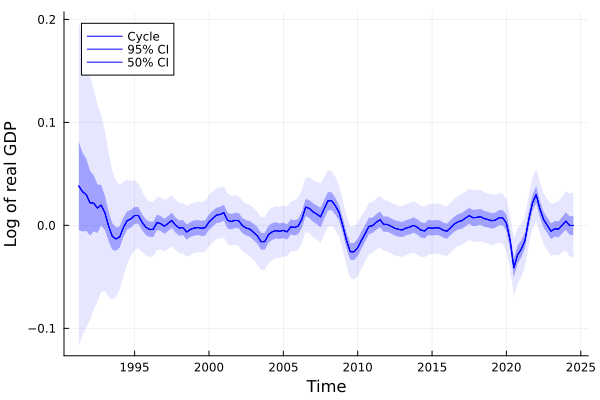

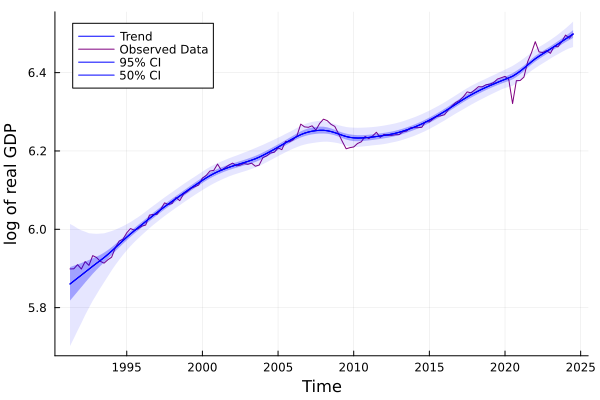

"c:\\Users\\marti\\OneDrive - University of Copenhagen\\Økonomi\\9. semester\\Empirical macro\\State-Space-Model-Estimation-1\\Harvey\\results\\Estimated_trend.pdf"

In [48]:
# cycle

p = plot(xlabel="Time", ylabel="Log of real GDP")

# Plot Harvey estimates with credible intervals
plot!(p, dates, alpha_mean[:, 5], label="Cycle", color=:blue)
#add 95% credible interval
plot!(p, dates, alpha_mean[:, 5],
        ribbon=(alpha_mean[:, 5] .- alpha_lower[:, 5],
                alpha_upper[:, 5] .- alpha_mean[:, 5]),
        fillalpha=0.1, color=:blue, label="95% CI")
#add 68% credible interval
plot!(p, dates, alpha_mean[:, 5],
        ribbon=(alpha_mean[:, 5] .- alpha_lower_68[:, 5],
                alpha_upper_68[:, 5] .- alpha_mean[:, 5]),
        fillalpha=0.3, color=:blue, label="50% CI")




# Adjust legend position if necessary
plot!(p, legend=:topleft)

# Display the plot
display(p)

#save
savefig(p, "Estimated_Cycle.pdf")




# trend

p = plot(xlabel="Time", ylabel="log of real GDP")

# Plot Harvey estimates with credible intervals
plot!(p, dates, alpha_mean[:, 1], label="Trend", color=:blue)
# add real data
plot!(p, dates, y, label="Observed Data", color=:Purple)
#add 95% credible interval
plot!(p, dates, alpha_mean[:, 1],
        ribbon=(alpha_mean[:, 1] .- alpha_lower[:, 1],
                alpha_upper[:, 1] .- alpha_mean[:, 1]),
        fillalpha=0.1, color=:blue, label="95% CI")
#add 68% credible interval
plot!(p, dates, alpha_mean[:, 1],
        ribbon=(alpha_mean[:, 1] .- alpha_lower_68[:, 1],
                alpha_upper_68[:, 1] .- alpha_mean[:, 1]),
        fillalpha=0.3, color=:blue, label="50% CI")




# Adjust legend position if necessary
plot!(p, legend=:topleft)

# Display the plot
display(p)

#save
savefig(p, "Estimated_trend.pdf")





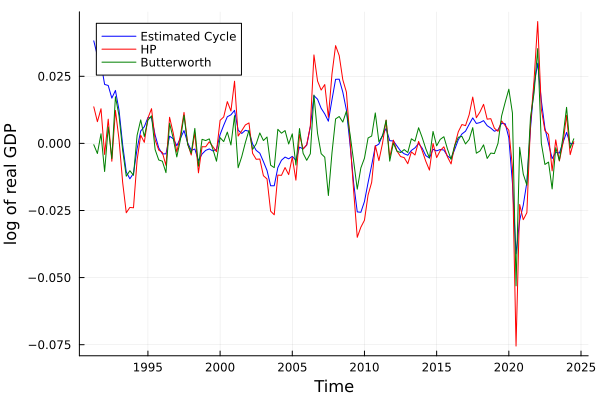

"c:\\Users\\marti\\OneDrive - University of Copenhagen\\Økonomi\\9. semester\\Empirical macro\\State-Space-Model-Estimation-1\\Harvey\\results\\HP_comparison_cycle.pdf"

In [49]:


p = plot(xlabel="Time", ylabel="log of real GDP")


# Plot Harvey estimates with credible intervals
plot!(p, dates, alpha_mean[:, 5], label="Estimated Cycle", color=:blue)


# Plot HP-filtered data
plot!(p, dates, cycle_hp, label="HP", color=:red)

# Plot Butterworth-filtered data
plot!(p, dates, cycle_butterworth, label="Butterworth", color=:green)

# Adjust legend position if necessary
plot!(p, legend=:topleft)

# Display the plot
display(p)

savefig(p, "HP_comparison_cycle.pdf")



### Plot trend and real data

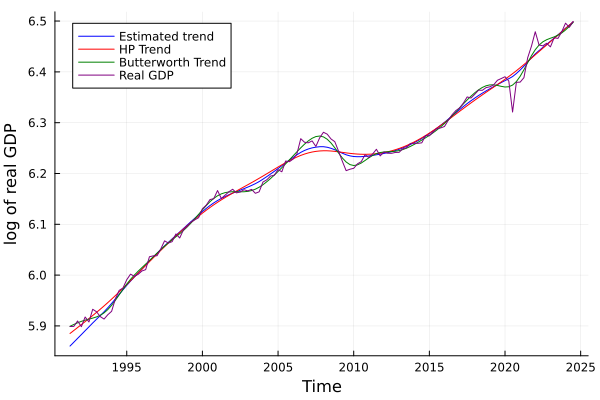

"c:\\Users\\marti\\OneDrive - University of Copenhagen\\Økonomi\\9. semester\\Empirical macro\\State-Space-Model-Estimation-1\\Harvey\\results\\HP_comparison_trend.pdf"

In [50]:


p = plot(xlabel="Time", ylabel="log of real GDP")

# Plot Harvey tred
plot!(p, dates, alpha_mean[:, 1], label="Estimated trend", color=:blue)

#plot hp trend
plot!(p, dates, hp, label="HP Trend", color=:red)

#plot butterworth trend
plot!(p, dates, trend_butterworth, label="Butterworth Trend", color=:green)

# Plot real GDP
plot!(p, dates, y, label="Real GDP", color=:purple)



# Adjust legend position if necessary
plot!(p, legend=:topleft)

# Display the plot
display(p)

savefig(p, "HP_comparison_trend.pdf")



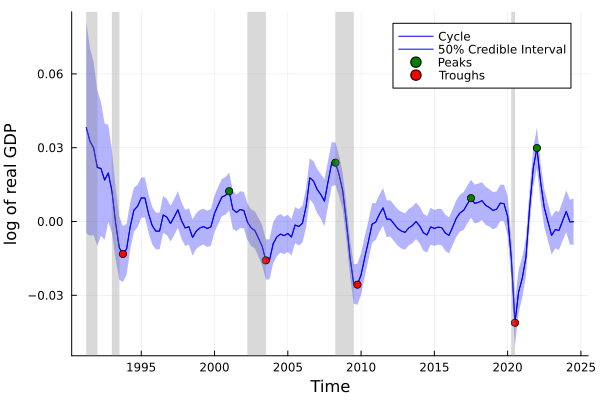

"c:\\Users\\marti\\OneDrive - University of Copenhagen\\Økonomi\\9. semester\\Empirical macro\\State-Space-Model-Estimation-1\\Harvey\\results\\Cycle_with_peaks_troughs.pdf"

In [51]:
#Identifying peaks and troughs in the cycle
cycle = alpha_mean[:, end-1]
cycle_lower = alpha_lower_68[:, end-1]
cycle_upper = alpha_upper_68[:, end-1]



# Identify where cycle crosses zero
zero_crossings = findall(i -> cycle_upper[i]*cycle_upper[i+1] < 0, 1:length(cycle)-1)
# add last index to zero crossings
push!(zero_crossings, length(cycle))



# Identify peaks and troughs between zero-crossings
peaks = []
peak_indices = []
troughs = []
trough_indices = []

for i in 1:(length(zero_crossings)-1)
    # Define the segment between zero crossings
    start_idx = zero_crossings[i] + 1
    end_idx   = zero_crossings[i+1]
    segment = cycle[start_idx:end_idx]

    # Find local maximum (peak) in this interval
    max_val = maximum(segment)
    max_idx = argmax(segment) + start_idx - 1  # Convert segment index to full index
    
    # Find local minimum (trough) in this interval
    min_val = minimum(segment)
    min_idx = argmin(segment) + start_idx - 1

    # check if absolute value of trough is bigger than peak
    if (abs(min_val) > abs(max_val))
        push!(troughs, min_val)
        push!(trough_indices, min_idx)
    end
    if (abs(max_val) > abs(min_val))
        push!(peaks, max_val)
        push!(peak_indices, max_idx)
    end

end

#plot the cycle with peaks and troughs
p = plot(dates, cycle, label="Cycle", color=:blue)

# add credible intervals
plot!(dates, cycle, ribbon=(cycle .- cycle_lower, cycle_upper .- cycle), fillalpha=0.3, label="50% Credible Interval", color=:blue)

# add peaks and troughs
scatter!(p, dates[peak_indices], peaks, label="Peaks", color=:green)
scatter!(p, dates[trough_indices], troughs, label="Troughs", color=:red)
xlabel!("Time")
ylabel!("log of real GDP")
# title!("Cycle with Peaks and Troughs")

for (start, stop) in recession_periods
    vspan!(p, [dates[start], dates[stop]], fillcolor=:gray, alpha=0.3, label=false)
end



display(p)

#save
savefig(p, "Cycle_with_peaks_troughs.pdf")




In [52]:

expansion_durations = Float64[]
contraction_durations = Float64[]
expansion_amplitudes = Float64[]
contraction_amplitudes = Float64[]


peak_to_peak_durations = Float64[]
trough_to_trough_durations = Float64[]


num_cycles = min(length(peak_indices), length(trough_indices))


for i in 1:(num_cycles) 
    # Expansion: trough[i] to peak[i]
    exp_dur = dates[peak_indices[i]] - dates[trough_indices[i]]
    push!(expansion_durations, exp_dur)
    exp_amp = peaks[i]
    push!(expansion_amplitudes, exp_amp)
    con_amp = troughs[i]
    push!(contraction_amplitudes, con_amp)
end

for i in 1:(num_cycles-1)
    # Contraction: peak[i] to trough[i+1]
    con_dur = dates[trough_indices[i+1]] - dates[peak_indices[i]]
    push!(contraction_durations, con_dur)
end

# For full cycle durations (peak-to-peak and trough-to-trough):
for i in 1:(length(peak_indices)-1)
    p2p = dates[peak_indices[i+1]] - dates[peak_indices[i]]
    push!(peak_to_peak_durations, p2p)
end

for i in 1:(length(trough_indices)-1)
    t2t = dates[trough_indices[i+1]] - dates[trough_indices[i]]
    push!(trough_to_trough_durations, t2t)
end

println("Expansion Durations: ", expansion_durations)
println("Contraction Durations: ", contraction_durations)
println("Peak-to-Peak Durations: ", peak_to_peak_durations)
println("Trough-to-Trough Durations: ", trough_to_trough_durations)
println("Expansion Amplitudes: ", expansion_amplitudes)
println("Contraction Amplitudes: ", contraction_amplitudes)


# Average characteristics:
avg_expansion_duration = mean(expansion_durations)
avg_contraction_duration = mean(contraction_durations)
avg_peak_to_peak_duration = mean(peak_to_peak_durations)
avg_trough_to_trough_duration = mean(trough_to_trough_durations)
avg_expansion_amplitude = mean(expansion_amplitudes)
avg_contraction_amplitude = mean(contraction_amplitudes)

println("Average Expansion Duration: ", avg_expansion_duration)
println("Average Contraction Duration: ", avg_contraction_duration)
println("Average Peak-to-Peak Duration: ", avg_peak_to_peak_duration)
println("Average Trough-to-Trough Duration: ", avg_trough_to_trough_duration)
println("Average Expansion Amplitude: ", avg_expansion_amplitude)
println("Average Contraction Amplitude: ", avg_contraction_amplitude)


# time with significantly positive and negative cycle
count_above = count(x -> x > 0, cycle_lower)
count_below = count(x -> x < 0, cycle_upper)

println("Quarters with significantly positive cycle: ", count_above)
println("Quarters with significantly negative cycle: ", count_below)





Expansion Durations: [7.25, 4.75, 7.75, 1.5]
Contraction Durations: [2.5, 1.5, 3.0]
Peak-to-Peak Durations: [7.25, 9.25, 4.5]
Trough-to-Trough Durations: [9.75, 6.25, 10.75]
Expansion Amplitudes: [0.01231008498282675, 0.02391528843663995, 0.009491804410183642, 0.029864205398552224]
Contraction Amplitudes: [-0.0131872679822687, -0.015800701717230494, -0.025667492488786716, -0.04116220473352164]
Average Expansion Duration: 5.3125
Average Contraction Duration: 2.3333333333333335
Average Peak-to-Peak Duration: 7.0
Average Trough-to-Trough Duration: 8.916666666666666
Average Expansion Amplitude: 0.018895345807050642
Average Contraction Amplitude: -0.023954416730451886
Quarters with significantly positive cycle: 21
Quarters with significantly negative cycle: 16


## Historical data

In [53]:
file_path = "C:/Users/marti/OneDrive - University of Copenhagen/Økonomi/9. semester/Empirical macro/State-Space-Model-Estimation-1/Harvey/data/Data 1870-2023.xlsx"
sheet_name = "Sheet 1"
sheet_name = "Sheet1"

data = XLSX.readtable(file_path, sheet_name) |> DataFrame

println(data)

num_obs = size(data, 1)
println("Number of observations: ", num_obs)



153×2 DataFrame
 Row │ 1870  1227    
     │ Any   Any     
─────┼───────────────
   1 │ 1871  1238
   2 │ 1872  1302.0
   3 │ 1873  1299.0
   4 │ 1874  1333.0
   5 │ 1875  1355.0
   6 │ 1876  1384.0
   7 │ 1877  1346.0
   8 │ 1878  1399.0
   9 │ 1879  1445.0
  10 │ 1880  1480.0
  11 │ 1881  1496.0
  12 │ 1882  1552.0
  13 │ 1883  1606.0
  14 │ 1884  1616.0
  15 │ 1885  1627.0
  16 │ 1886  1689.0
  17 │ 1887  1747.0
  18 │ 1888  1766.0
  19 │ 1889  1792.0
  20 │ 1890  1897.0
  21 │ 1891  1934.0
  22 │ 1892  1980.0
  23 │ 1893  2017.0
  24 │ 1894  2059.0
  25 │ 1895  2175.0
  26 │ 1896  2254.0
  27 │ 1897  2305.0
  28 │ 1898  2349.0
  29 │ 1899  2449.0
  30 │ 1900  2531.0
  31 │ 1901  2634.0
  32 │ 1902  2694.0
  33 │ 1903  2853.0
  34 │ 1904  2920.0
  35 │ 1905  2971.0
  36 │ 1906  3057.0
  37 │ 1907  3173.0
  38 │ 1908  3265.0
  39 │ 1909  3388.0
  40 │ 1910  3491.0
  41 │ 1911  3680.0
  42 │ 1912  3697.0
  43 │ 1913  3836.0
  44 │ 1914  4057.0
  45 │ 1915  3752.0
  46 │ 1916  3901.0


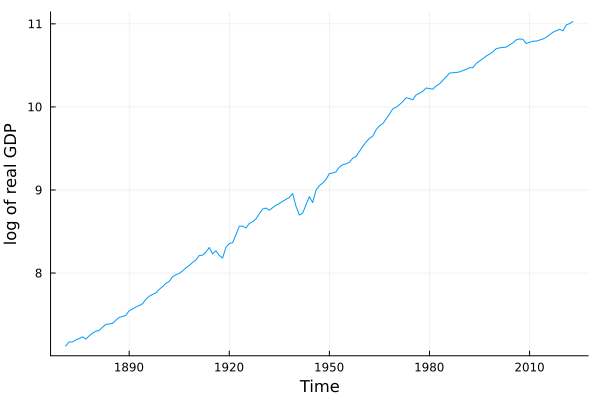

In [54]:
y = data[:, 2]
y = log.(y)
dates = data[:, 1]


for i in 1:length(dates)
    year = parse(Int, dates[i][1:4])
    dates[i] = year 
end

dates = Float64.(dates)

# plot
p = plot(dates, y, xlabel="Time", ylabel="log of real GDP", label=false)

In [55]:
using JLD2

@load "states_harvey_historic.jld2" alpha_mean alpha_lower alpha_upper alpha_lower_68 alpha_upper_68

5-element Vector{Symbol}:
 :alpha_mean
 :alpha_lower
 :alpha_upper
 :alpha_lower_68
 :alpha_upper_68

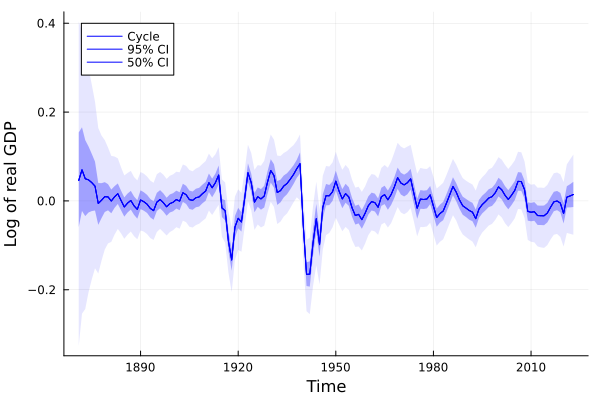

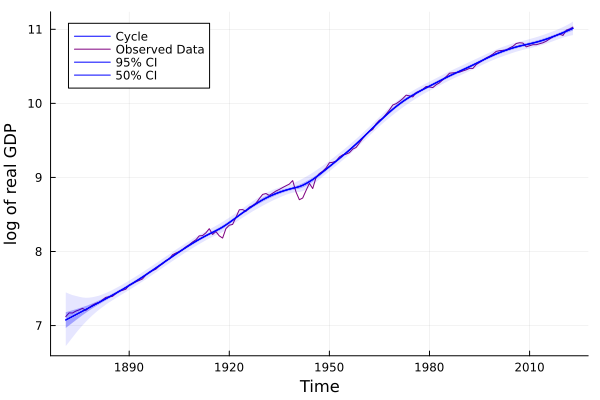

"c:\\Users\\marti\\OneDrive - University of Copenhagen\\Økonomi\\9. semester\\Empirical macro\\State-Space-Model-Estimation-1\\Harvey\\results\\Estimated_trend.pdf"

In [56]:
# cycle

p = plot(xlabel="Time", ylabel="Log of real GDP")

# Plot Harvey estimates with credible intervals
plot!(p, dates, alpha_mean[:, 5], label="Cycle", color=:blue)
#add 95% credible interval
plot!(p, dates, alpha_mean[:, 5],
        ribbon=(alpha_mean[:, 5] .- alpha_lower[:, 5],
                alpha_upper[:, 5] .- alpha_mean[:, 5]),
        fillalpha=0.1, color=:blue, label="95% CI")
#add 68% credible interval
plot!(p, dates, alpha_mean[:, 5],
        ribbon=(alpha_mean[:, 5] .- alpha_lower_68[:, 5],
                alpha_upper_68[:, 5] .- alpha_mean[:, 5]),
        fillalpha=0.3, color=:blue, label="50% CI")




# Adjust legend position if necessary
plot!(p, legend=:topleft)

# Display the plot
display(p)

#save
savefig(p, "Estimated_Cycle.pdf")




# trend

p = plot(xlabel="Time", ylabel="log of real GDP")

# Plot Harvey estimates with credible intervals
plot!(p, dates, alpha_mean[:, 1], label="Cycle", color=:blue)
# add real data
plot!(p, dates, y, label="Observed Data", color=:Purple)
#add 95% credible interval
plot!(p, dates, alpha_mean[:, 1],
        ribbon=(alpha_mean[:, 1] .- alpha_lower[:, 1],
                alpha_upper[:, 1] .- alpha_mean[:, 1]),
        fillalpha=0.1, color=:blue, label="95% CI")
#add 68% credible interval
plot!(p, dates, alpha_mean[:, 1],
        ribbon=(alpha_mean[:, 1] .- alpha_lower_68[:, 1],
                alpha_upper_68[:, 1] .- alpha_mean[:, 1]),
        fillalpha=0.3, color=:blue, label="50% CI")




# Adjust legend position if necessary
plot!(p, legend=:topleft)

# Display the plot
display(p)

#save
savefig(p, "Estimated_trend.pdf")





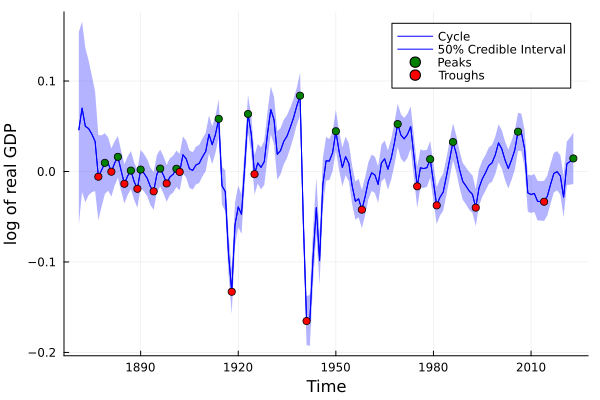

In [57]:
#Identifying peaks and troughs in the cycle
trend = alpha_mean[:, 1]
cycle = alpha_mean[:, end-1]
cycle_lower = alpha_lower_68[:, end-1]
cycle_upper = alpha_upper_68[:, end-1]



zero_crossings = findall(i -> cycle[i]*cycle[i+1] < 0, 1:length(cycle)-1)
push!(zero_crossings, length(cycle))



# Identify peaks and troughs between zero-crossings
peaks = []
peak_indices = []
troughs = []
trough_indices = []


last_extremum = nothing

for i in 1:(length(zero_crossings)-1)
    # Define the segment between zero crossings
    start_idx = zero_crossings[i] + 1
    end_idx   = zero_crossings[i+1]
    segment = cycle[start_idx:end_idx]

    # Find local maximum (peak) in this interval
    max_val = maximum(segment)
    max_idx = argmax(segment) + start_idx - 1

    # Find local minimum (trough) in this interval
    min_val = minimum(segment)
    min_idx = argmin(segment) + start_idx - 1

    # Determine which extremum is dominant in this segment
    # and enforce alternation
    if abs(min_val) > abs(max_val)
        # We have a trough candidate
        if last_extremum != :trough
            push!(troughs, min_val)
            push!(trough_indices, min_idx)
            last_extremum = :trough
        end
    elseif abs(max_val) > abs(min_val)
        # We have a peak candidate
        if last_extremum != :peak
            push!(peaks, max_val)
            push!(peak_indices, max_idx)
            last_extremum = :peak
        end
    else
        # In case of a tie, you can decide to pick one or none.
        # For example, if last_extremum was a trough, pick a peak now, and vice versa:
        if last_extremum == :trough 
            push!(peaks, max_val)
            push!(peak_indices, max_idx)
            last_extremum = :peak
        else
            push!(troughs, min_val)
            push!(trough_indices, min_idx)
            last_extremum = :trough
        end
    end
end


#plot the cycle with peaks and troughs
p = plot(dates, cycle, label="Cycle", color=:blue)

# add credible intervals
plot!(dates, cycle, ribbon=(cycle .- cycle_lower, cycle_upper .- cycle), fillalpha=0.3, label="50% Credible Interval", color=:blue)

# add peaks and troughs
scatter!(p, dates[peak_indices], peaks, label="Peaks", color=:green)
scatter!(p, dates[trough_indices], troughs, label="Troughs", color=:red)
xlabel!("Time")
ylabel!("log of real GDP")
# title!("Cycle with Peaks and Troughs")


display(p)




In [58]:

expansion_durations = Float64[]
contraction_durations = Float64[]
expansion_amplitudes = Float64[]
contraction_amplitudes = Float64[]


peak_to_peak_durations = Float64[]
trough_to_trough_durations = Float64[]


num_cycles = min(length(peak_indices), length(trough_indices))


for i in 1:(num_cycles) 
    # Expansion: trough[i] to peak[i]
    exp_dur = dates[peak_indices[i]] - dates[trough_indices[i]]
    push!(expansion_durations, exp_dur)
    exp_amp = peaks[i]
    push!(expansion_amplitudes, exp_amp)
    con_amp = troughs[i]
    push!(contraction_amplitudes, con_amp)
end

for i in 1:(num_cycles-1)
    # Contraction: peak[i] to trough[i+1]
    con_dur = dates[trough_indices[i+1]] - dates[peak_indices[i]]
    push!(contraction_durations, con_dur)
end

# For full cycle durations (peak-to-peak and trough-to-trough):
for i in 1:(length(peak_indices)-1)
    p2p = dates[peak_indices[i+1]] - dates[peak_indices[i]]
    push!(peak_to_peak_durations, p2p)
end

for i in 1:(length(trough_indices)-1)
    t2t = dates[trough_indices[i+1]] - dates[trough_indices[i]]
    push!(trough_to_trough_durations, t2t)
end

println("Expansion Durations: ", expansion_durations)
println("Contraction Durations: ", contraction_durations)
println("Peak-to-Peak Durations: ", peak_to_peak_durations)
println("Trough-to-Trough Durations: ", trough_to_trough_durations)
println("Expansion Amplitudes: ", expansion_amplitudes)
println("Contraction Amplitudes: ", contraction_amplitudes)


# Average characteristics:
avg_expansion_duration = mean(expansion_durations)
avg_contraction_duration = mean(contraction_durations)
avg_peak_to_peak_duration = mean(peak_to_peak_durations)
avg_trough_to_trough_duration = mean(trough_to_trough_durations)
avg_expansion_amplitude = mean(expansion_amplitudes)
avg_contraction_amplitude = mean(contraction_amplitudes)

println("Average Expansion Duration: ", avg_expansion_duration)
println("Average Contraction Duration: ", avg_contraction_duration)
println("Average Peak-to-Peak Duration: ", avg_peak_to_peak_duration)
println("Average Trough-to-Trough Duration: ", avg_trough_to_trough_duration)
println("Average Expansion Amplitude: ", avg_expansion_amplitude)
println("Average Contraction Amplitude: ", avg_contraction_amplitude)


# time with positve and negative cycle
count_above = count(x -> x > 0, cycle)
count_below = count(x -> x < 0, cycle)

println("Years with positive cycle: ", count_above)
println("Years with negative cycles: ", count_below)

# time with significantly positive and negative cycle
count_above = count(x -> x > 0, cycle_lower)
count_below = count(x -> x < 0, cycle_upper)

println("Years with significantly positive cycle: ", count_above)
println("Years with significantly negative cycles: ", count_below)





Expansion Durations: [2.0, 2.0, 2.0, 1.0, 2.0, 3.0, 12.0, 5.0, 14.0, 9.0, 11.0, 4.0, 5.0, 13.0, 9.0]
Contraction Durations: [2.0, 2.0, 2.0, 4.0, 2.0, 1.0, 4.0, 2.0, 2.0, 8.0, 6.0, 2.0, 7.0, 8.0]
Peak-to-Peak Durations: [4.0, 4.0, 3.0, 6.0, 5.0, 13.0, 9.0, 16.0, 11.0, 19.0, 10.0, 7.0, 20.0, 17.0]
Trough-to-Trough Durations: [4.0, 4.0, 4.0, 5.0, 4.0, 4.0, 16.0, 7.0, 16.0, 17.0, 17.0, 6.0, 12.0, 21.0]
Expansion Amplitudes: [0.00956605266649547, 0.016214075388749076, 0.0009923709844876047, 0.0021058583651513505, 0.003251282808207243, 0.0030293137460209105, 0.05820985615502789, 0.06355853435829834, 0.08379813037541013, 0.04451416761940038, 0.052414621008535035, 0.013582808072213083, 0.03257717105083405, 0.04402357006785367, 0.014441503481365825]
Contraction Amplitudes: [-0.005800767569541777, -0.00025603982912176284, -0.013608280761896453, -0.019150467638096167, -0.02196112760233483, -0.013207204592025347, -0.0004604361431862671, -0.13293773881306772, -0.002936406903519326, -0.1653018404603